# The Implementation of AE, VAE and GAN
This implementation includes the theoritical explamentation and training performance of three different kinds of generative deep learning models, that is, Autoencoder, Variational Autoencoder and Generative Adversarial Network on MNIST dataset. 

The questions will be covered are:
* Autoencoder: model introduction and implementation
* Variational Autoencoder: model introduction and implementation, theoritical explamentation
* The difference between Autoencoder and Variational Autoencoder
* Generative Adversarial Network: model introduction and implementation

**Note**: Models are created in Keras

## Part 2:  Variational Autoencoder

#### Preparing:  Import TensorFlow and other libraries

In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.datasets import mnist
import numpy as np
from keras import backend 
from keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout, Lambda,  UpSampling2D
from keras.models import Model
from keras.layers import Conv2DTranspose, Reshape,Activation, LeakyReLU, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
from plot import *
import datetime
import cv2

from IPython.display import display, Image, SVG

import warnings
warnings.filterwarnings('ignore')

#### Preparing:  Load the MNIST dataset
There are 60,000 MNIST image totally in the train set and 10,000 MNIST image totally in the test set. Each MNIST image is originally with shape (28, 28), each of which is between 0-255 and represents the intensity of a pixel. We normalize the images to the range (0, 1) and reshape them to (28, 28, 1)

In [31]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

#### Preparing: the CallBack to save the training results

In [32]:
class CustomCallback(Callback):
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, decoder, z_dim ):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.decoder = decoder
        self.z_dim = z_dim
        
    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.z_dim))
            reconst = self.decoder.predict(np.array(z_new))[0].squeeze()
            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)
                
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1
    
         
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr
    
    return LearningRateScheduler(schedule)

#### Introduction
Precisely, variational autoencoder is an autoencoder that learns a latent variable model for its input data. Instead of letting the neural network learn an arbitrary function, the parameters of a probability distribution are learned to model the data. Sampling points from this distribution can generate new samples. After training the VAE model, the encoder can be used to generate latent vectors. The decoder can be used to generate MNIST digits by sampling the latent vector from a Gaussian distribution with mean = 0 and std = 1.

#### Theoritical Explamentation of VAE

Assuming the observed variable $x$(image) is a random sample from an unknown underlying process with the unknown  distribution $p^*(x)$, we are interested in approximate the distribution with a chosen model $p_\theta(x)$ such that:
$$ p_\theta(x) \approx p^*(x)$$
Under the maximum log$-$likelihood(ML) criterion, we attempt to find the parameter $\theta$ maximize the log$-$probabilities which can be expressed as 
$$ \text{log} p_\theta(D) = \sum_{x\in D}\text{log} p_\theta(x)$$
where D means the dataset containing all iid image. 
We are interested in using gradient to iteratively hill$-$climb to a local optimum of the ML criterion. Since the calculation of batch gradient descent $\bigtriangledown_\theta \text{log} p_\theta(D)$ is very expensive, the most efficient way for optimization is **stochastic gradient descent** by using randomly drawn minibenches of data with size $N_M$. Therefore, the unbiased estimator of the ML stochastic gradients are:
$$ \bigtriangledown_\theta \text{log} p_\theta(M) = \sum_{x\in M}\bigtriangledown_\theta \text{log} p_\theta(x)$$

#### Decoder
Since the distribution $p_\theta(x)$ can be very complex, we could introduce **latent variables** $z$ to represent the observed variables
$$ p_\theta(x) = \int p_\theta(x, z)dz = \int p_\theta(z)p_\theta(x|z) dz $$
where $p(z)$ is the prior distribution over z. 

#### Encoder
The posterior distribution p_\theta(z|x) of $p_\theta(x)$ satisfiys that 
$$ p_\theta(z|x) = \frac{p_\theta(x, z)}{p_\theta(x)} $$
Since $p_\theta(x, z)$ is tractable, a tractable $p_\theta(z|x)$ leads to a tractable $p_\theta$. In most situations, the posterior is intractable, thus we introduce a parametric inference model(or encoder) $q_{\phi}(z|x)$ such that 
$$ q_{\phi}(z|x) \approx p_\theta(z|x) $$

#### Evidence lower bound ( ELBO )
For any choice of inference model, we can express the log$-$likelihood as 
$$ \text{log} p_\theta(x) = \mathbb{E}_{q_\phi(z|x)}[\text{log}p_\theta(x)] = \mathbb{E}_{q_\phi(z|x)}\left[\text{log}\frac{p_\theta(x, z)}{q_\phi(z|x)}\right] + \mathbb{E}_{q_\phi(z|x)}\left[\text{log}\frac{q_\phi(z|x)}{p_\theta(z|x)}\right]$$

The first term is our optimization objective: the evidence lower bound
$$ L_{\theta, \phi}(x) = \mathbb{E}_{q_\phi(z|x)}\left[\text{log}\frac{p_\theta(x, z)}{q_\phi(z|x)}\right] = \text{log} p_\theta(x) - D_{KL}(q_\phi(z|x)|p_\theta(z|x)) $$

Because the gradient of ELBO for $\phi$ is difficult to obtain, the reparameterization trick for computing the gradient can be helpful. 

#### Reprarameterization trick
![A diagram of a generator and discriminator](image/VAE2.png)
Expressing the random variable $z\sim q_{\phi}(z|x)$ as another random variable $\epsilon$ which from the distribution $p(\epsilon)$, that is 
$$ z = g(\epsilon, \phi, x)$$
Therefore, the gradient of ELBO becomes 
$$ L_{\theta, \phi}(x) = \mathbb{E}_{p_(\epsilon)}\left[\text{log}\frac{p_\theta(x, z)}{q_\phi(z|x)}\right] = \text{log}p_\theta(x, z) - \text{log}q_\phi(z|x) $$

A common choice is a simple factorized Gaussian encoder
$$ q_\phi(z|x) = N(z|\mu, \text{diag}(\sigma^2)) $$
Therefore, after reparameterization, 
$$ \epsilon \sim N(0, 1)$$
$$ (\mu, \text{log} \sigma) = ENcoderNeuralNet_{\phi}(x)$$
$$ z= \mu + \sigma * \epsilon $$


#### The Model
The process of VAE can be described by this figure:
![A diagram of a generator and discriminator](image/VAE1.png)



#### Training:
* An encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. 
* **We randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. **
* A decoder network maps these latent space points back to the original input data.
* two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs, and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term.

**Assumption**: There is no correlation between any of the dimensions in the latend space. 

#### Parameters for training

In [33]:
# parameters for VAE
VAE_input_dim = (28,28,1)

VAE_encoder_conv_filters = [32,64,64, 64]
VAE_encoder_conv_kernel_size = [3,3,3,3]
VAE_encoder_conv_strides = [1,2,2,1]

VAE_decoder_conv_t_filters =  [64,64,32,1]
VAE_decoder_conv_t_kernel_size = [3,3,3,3]
VAE_decoder_conv_t_strides = [1,2,2,1]

VAE_z_dim = 2
VAE_n_layers_encoder = len(VAE_encoder_conv_filters)
VAE_n_layers_decoder = len(VAE_decoder_conv_t_filters)

learning_rate = 0.0005
r_loss_factor = 1000

BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

# run params
SECTION = 'self_vae'
VAE_RUN_ID = '0002'
VAE_DATA_NAME = 'digits'
VAE_RUN_FOLDER = 'run/{}/'.format(SECTION)
VAE_RUN_FOLDER += '_'.join([VAE_RUN_ID, VAE_DATA_NAME])

if not os.path.exists(VAE_RUN_FOLDER):
    os.mkdir(VAE_RUN_FOLDER)
    os.mkdir(os.path.join(VAE_RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(VAE_RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(VAE_RUN_FOLDER, 'weights'))

#### Build the encoder
* Input: image
* Output: mu and sigma

#### Sampling from the distribution:(**repamameterization trick**)
$$ z = mu + sigma * epsilon $$
where epsilon is a point sampled from the standard normal distribution. All points in the same neighborhood produce very similar images when decoded.

Output: sampling point from the normal distribution by the parameters 

#### Build the decoder 
* Input: sampling point 
* Output: image

#### Joining the Encoder and Decoder
Takes an image and pass it through the encoder and back out through the decoder to generate a reconstruction
* input: the same as the input to the encoder
* output: the output from the encoder passed through the decoder

In [34]:
# VAE encoder
VAE_encoder_input = Input(shape= VAE_input_dim, name='VAE_encoder_input')
x = VAE_encoder_input

for i in range(VAE_n_layers_encoder):
    conv_layer = Conv2D(
        filters = VAE_encoder_conv_filters[i]
        , kernel_size = VAE_encoder_conv_kernel_size[i]
        , strides = VAE_encoder_conv_strides[i]
        , padding = 'same'
        , name = 'encoder_conv_' + str(i)
        )
    x = conv_layer(x)
    # x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # x = Dropout(rate = 0.25)(x)
VAE_shape_before_flattening = backend.int_shape(x)[1:]
x = Flatten()(x)

mu = Dense(VAE_z_dim, name = "mu")(x)
# logarithm of the variance, take number in the range (-\infty, +\infty)
log_var = Dense(VAE_z_dim, name = "log_var")(x)
# output the values of mu, log_var for a given input image
#VAE_encoder_mu_log_var = Model(VAE_encoder_input, (mu, log_var))

def sampling(args):
    mu, log_var = args
    epsilon = backend.random_normal(shape=backend.shape(mu), mean=0., stddev=1.)
    return mu + backend.exp(log_var / 2) * epsilon
# Lambda samples a point in the latent space from the normal distribution defined by mu and log_var
VAE_encoder_output = Lambda(sampling, name='VAE_encoder_output')([mu, log_var]) 
VAE_encoder = Model(VAE_encoder_input, VAE_encoder_output)
#VAE_encoder.summary()

#Decoder
VAE_decoder_input = Input(shape=(VAE_z_dim,), name='VAE_decoder_input')

x = Dense(np.prod(VAE_shape_before_flattening))(VAE_decoder_input)
x = Reshape(VAE_shape_before_flattening)(x)

for i in range(VAE_n_layers_decoder):
    conv_t_layer = Conv2DTranspose(
        filters = VAE_decoder_conv_t_filters[i]
        , kernel_size = VAE_decoder_conv_t_kernel_size[i]
        , strides = VAE_decoder_conv_t_strides[i]
        , padding = 'same'
        , name = 'decoder_conv_t_' + str(i)
        )
    x = conv_t_layer(x)
    if i < VAE_n_layers_decoder - 1:
        #x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        #x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

VAE_decoder_output = x
VAE_decoder = Model(VAE_decoder_input, VAE_decoder_output)
#VAE_decoder.summary()

model_input = VAE_encoder_input
model_output = VAE_decoder(VAE_encoder_output)
VAE_model = Model(model_input, model_output)

#### Model compile 
#### Loss function 
* RMSE: reconstruction loss (the loss between images and their reconstruction images)
* KL divergence: measuring how much one probability distribution differs from another

$$ D_{KL}[N(\mu, \sigma)|N(0, 1)] = \frac 12 \sum(1+\log(\sigma^2)-\mu^2 - \sigma^2)) $$
KL divergence term penalizes the network from encoding observations that differ significantly from the parameters of a standard normal distribution. The loss function for a VAE is the addition of **weighted** reconstruction loss and KL divergence loss. 

In [29]:
# reconstruction loss 
# KL divergenve: distance of distribution, close to mu and sigma 
def vae_r_loss(y_true, y_pred):
    r_loss = backend.mean(backend.square(y_true - y_pred), axis = [1,2,3])
    return r_loss_factor * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * backend.sum(1 + log_var - backend.square(mu) - backend.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return  r_loss + kl_loss

optimizer = Adam(lr=learning_rate)
VAE_model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])

custom_callback = CustomCallback(VAE_RUN_FOLDER, 500, INITIAL_EPOCH, decoder, z_dim )
lr_sched = step_decay_schedule(initial_lr = learning_rate, decay_factor= 1, step_size=1)

checkpoint_filepath=os.path.join(VAE_RUN_FOLDER, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
checkpoint2 = ModelCheckpoint(os.path.join(VAE_RUN_FOLDER, 'weights/weights.h5'), save_weights_only = True, verbose=1)

callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

VAE_model.fit(     
    x_train
    , x_train
    , batch_size = BATCH_SIZE
    , shuffle = True
    , epochs = 10
    , initial_epoch = INITIAL_EPOCH
    , callbacks = callbacks_list
)

Epoch 1/10
60000/60000 [==============================] - 24s 406us/step - loss: 51.8560 - vae_r_loss: 47.9774 - vae_kl_loss: 3.8786

Epoch 00001: saving model to run/self_vae/0002_digits/weights/weights-001-51.86.h5

Epoch 00001: saving model to run/self_vae/0002_digits/weights/weights.h5
Epoch 2/10
60000/60000 [==============================] - 23s 381us/step - loss: 50.3694 - vae_r_loss: 46.1885 - vae_kl_loss: 4.1809

Epoch 00002: saving model to run/self_vae/0002_digits/weights/weights-002-50.37.h5

Epoch 00002: saving model to run/self_vae/0002_digits/weights/weights.h5
Epoch 3/10
60000/60000 [==============================] - 23s 380us/step - loss: 49.4362 - vae_r_loss: 45.0555 - vae_kl_loss: 4.3806

Epoch 00003: saving model to run/self_vae/0002_digits/weights/weights-003-49.44.h5

Epoch 00003: saving model to run/self_vae/0002_digits/weights/weights.h5
Epoch 4/10
60000/60000 [==============================] - 22s 374us/step - loss: 48.7490 - vae_r_loss: 44.2253 - vae_kl_loss: 4

#### Result:
Comparing the original image and reconstructed image from autoencoder, the top row is the original digits, and the bottom row is the reconstructed digits.

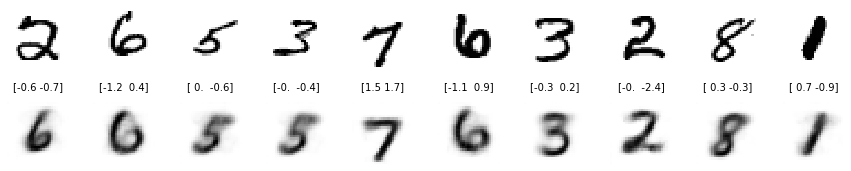

In [35]:
VAE_model.load_weights(os.path.join(VAE_RUN_FOLDER, 'weights/weights.h5'))

# select the test data randomly and plot 
example_idx = np.random.choice(range(len(x_test)), rand_selec_n_to_show)
example_images = x_test[example_idx]
z_points = VAE_encoder.predict(example_images)
reconst_images = VAE_decoder.predict(z_points)
plot_select(z_points, example_images, reconst_images, rand_selec_n_to_show)

### Explore the latent layer
The variational autoencoders has grouped digits that look alike into the same part of the latent space. Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar.

In this model, we can use it to generate new digits by choosing a random point in the latent space.

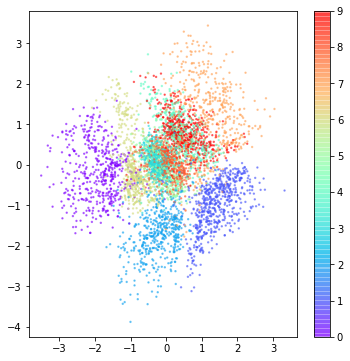

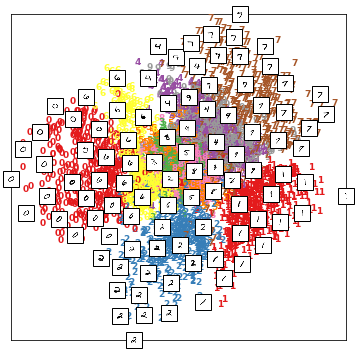

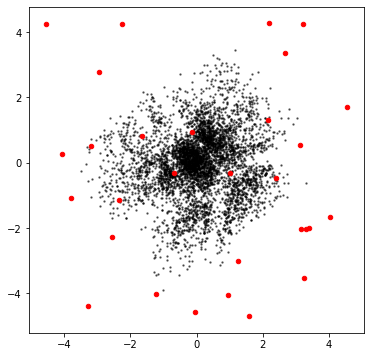

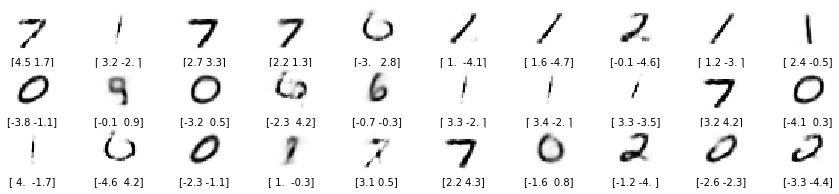

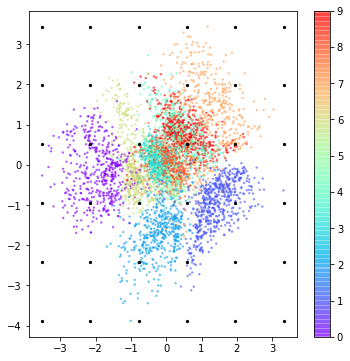

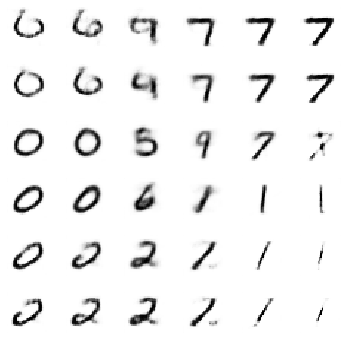

In [36]:
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

# the latent layer 
z_points = VAE_encoder.predict(example_images)
plot_latent_distribution(z_points, example_labels)

# Normalized the axis to show the distribution 
plot_embedding(z_points, example_images, example_labels)
# Random sampling some points
Plot_sampling(z_points, VAE_decoder)

# The overall latent space distribution 
plot_latentspace(z_points, example_labels, VAE_decoder)

### Comparing the Autoencoder and Variational Autoencoder
* Autoencoder: each image is mapped directly to a point in the latent space;
* Variational Autoencoder: each image is mapped to a multivariate normal distribition around a point in the latent space. 

The modification of Autoencoder to Variational Autoencoder is in the change of the encoder and the loss function. With this modification, the improvement of Variational Autoencoder comparing from Autoencoder are:
1. Sampling from the standard normal distribution, it is more likely to get a point that lies within the limits of what the VAE is used to seeing;
2. Less chance that large gaps will form between point clusters